In [1]:
import logging
import sys
import os.path
from collections import namedtuple
from itertools import chain

import emsa

import numpy as np
import pandas as pd
import scipy
from scipy import ndimage
from scipy import ndimage as ndi
from scipy.misc import imsave
import matplotlib.pyplot as plt

import torch
from torch.autograd import Variable
from torch import optim

import unet
from unet.utils import BinCounter

%pylab inline
plt.rcParams["figure.figsize"] = (12, 8)

Dataset = namedtuple('Dataset', ['image', 'mask', 'coords', 'radius'])

logger = logging.getLogger(__name__)

# Tool to debug the code in python
# import IPython
# IPython.embed()

Populating the interactive namespace from numpy and matplotlib


/home/mas/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['imsave']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
unet.config_logger("/dev/null")

In [3]:
def nonmaxima_suppression(img, return_mask=True):
    # smooth_img = img # ndi.gaussian_filter(img, 1)
    dilated = ndi.grey_dilation(img, (5,) * img.ndim)
    argmaxima = np.logical_and(img == dilated, img > 0.5)

    argwhere = np.argwhere(argmaxima)

    if not return_mask:
        return argwhere

    return argwhere, argmaxima

In [4]:
def inverse_argwhere(coords, shape, dtype):
    
    res = np.zeros(shape, dtype=dtype)
    intcoords = np.int_(np.round(coords))
    res[intcoords[:, 0], intcoords[:, 1], intcoords[:, 2]] = 1
    return res

In [5]:
def precision_and_recall(testing_coords, pred_coords, match_distance):
    w = scipy.spatial.distance_matrix(testing_coords, pred_coords)
    row_ind, col_ind = scipy.optimize.linear_sum_assignment(w)

    res = []
    for i in range(row_ind.shape[0]):
        if w[row_ind[i], col_ind[i]] <= match_distance:
            res.append(w[row_ind[i], col_ind[i]])

    precision = len(res) / len(pred_coords)
    recall = len(res) / len(testing_coords) 
    
    return precision, recall, len(res), len(pred_coords), len(testing_coords)

In [6]:
def reduce_metrics(results):
    
    tp = sum(i.tp for i in results)
    tp_fp = sum(i.tp_fp for i in results)
    tp_fn = sum(i.tp_fn for i in results)
    true_sums = np.array([i.true_sums for i in results])
    pred_sums = np.array([i.pred_sums for i in results])
    volumes = np.array([i.volumes for i in results])
    
    precision = tp / tp_fp
    recall = tp / tp_fn
    
    error = emsa.diff_vesicles_per_voxel(true_sums, pred_sums, volumes)
    
    return Metrics(precision, recall, tp, tp_fp, tp_fn,
                   error, true_sums, pred_sums, volumes)

In [7]:
def Dilation(labels):
    gauss = ndi.gaussian_filter(np.float32(labels), 3)
    soft_img =  np.uint8(gauss / np.max(gauss) *255)
    return soft_img   

In [8]:
logger.info("Creating the Network...")
num_classes = 2
unet_config = unet.UNetConfig(steps=2,
                              ndims=3,
                              num_classes=num_classes,
                              first_layer_channels=64,
                              num_input_channels=1,
                              two_sublayers=True)


unet_clsf = unet.UNetClassifier(unet_config).cuda() # .cuda() moves the network to GPU

2018-02-05 17:31:05,103 [__main__] Creating the Network...


In [9]:
unet_clsf.load_state_dict(torch.load('/cvlabdata2/home/mas/UNet-3D-Test0/network_200000.pth'))

In [10]:
# Load the stack which we want predict. 

base_path = "/cvlabdata1/home/marquez/vesicles/"
# file = "striatum_testing/Bouton 1" # Best
# file = "hipp_testing/Bouton 1" # Intermidiate
file = "striatum_testing/Bouton 4" # Worst

testing_x = np.float32(unet.load_volume(os.path.join(base_path, file, "img.tif")) / 255.0)
testing_coords, radius = np.load(os.path.join(base_path, file, "vesicles.npy"), encoding = 'bytes')
testing_coords = np.vstack(testing_coords)
radius = np.float_(radius)
mask = np.float32(unet.load_volume(os.path.join(base_path, file, "mask.tif")))
density = np.float32(unet.load_volume(os.path.join(base_path, file, "density.tif")))

In [11]:
hint_patch_shape=(64, 64, 64)
pred_stack = unet.predict_in_blocks(unet_clsf, testing_x, hint_patch_shape,
                                      output_function=unet_clsf.probability_output,
                                      verbose=False)[1]

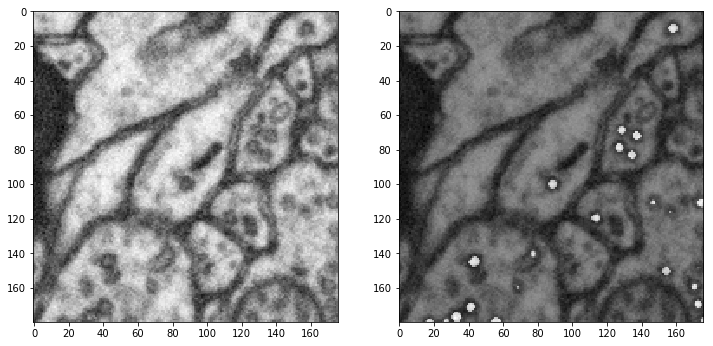

In [12]:
i = 50
plt.subplot(1, 2, 1)
plt.imshow(testing_x[i])
plt.subplot(1, 2, 2)
plt.imshow(pred_stack[i]+testing_x[i])
# plt.imshow(pred_stack[i])

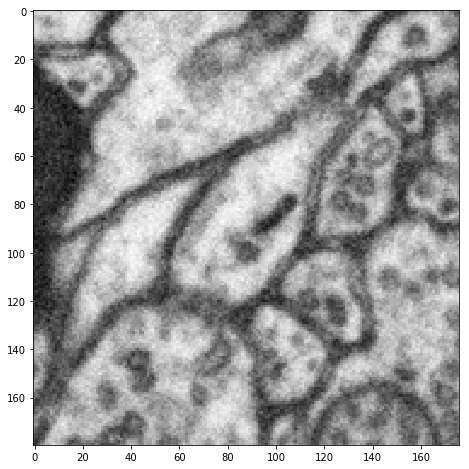

In [13]:
plt.imshow(testing_x[i])

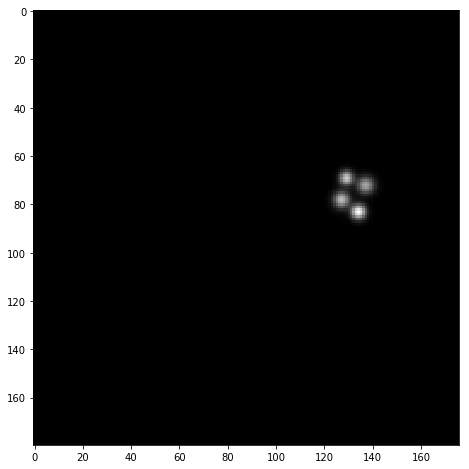

In [14]:
plt.imshow(density[i])

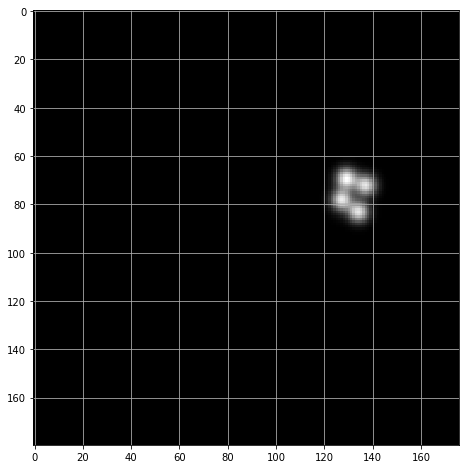

In [15]:
# Computing the Tp, Fp and Fn

# Load of the centers
ones = np.int64(np.round(testing_coords)) 

# Centers activation with Advanced Indexing
labels = np.zeros(mask.shape, dtype=np.int64)
labels[ones[:, 0], ones[:, 1], ones[:, 2]] = 1
labels = Dilation(labels)
plt.imshow(labels[i])
plt.grid()

In [16]:
# Pair between the prediction and the originals centres
pred_coords, pred_y = nonmaxima_suppression(pred_stack*mask, True) 
w = scipy.spatial.distance_matrix(testing_coords, pred_coords)
row_ind, col_ind = scipy.optimize.linear_sum_assignment(w)

In [18]:
# Delet the pair with a distance higher than 4
match_distance = 4
index_pred = []
index_testing = []
for i in range(row_ind.shape[0]):
    if w[row_ind[i], col_ind[i]] <= match_distance:
        index_pred.append(col_ind[i])
        index_testing.append(row_ind[i])
index_pred = np.hstack(index_pred)
index_testing = np.hstack(index_testing)
# index

In [19]:
# Green = True Positve
green_testing = np.zeros(mask.shape, dtype=np.int16)
ones_green_testing = np.int16(testing_coords[index_testing])
green_testing[ones_green_testing[:, 0], ones_green_testing[:, 1], ones_green_testing[:, 2]] = 1
green_testing = Dilation(green_testing)

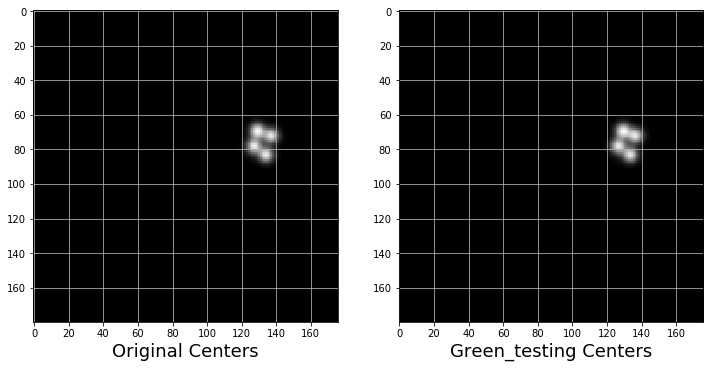

In [20]:
i = 50
plt.subplot(1, 2, 1)
plt.imshow(labels[i])
plt.xlabel("Original Centers", fontsize=18)
plt.grid()
plt.subplot(1, 2, 2)
plt.imshow(green_testing[i])
plt.xlabel("Green_testing Centers", fontsize=18)
plt.grid()

In [21]:
# Blue = false positive
index_blue = np.array(list(set(range(w.shape[1])) - set(index_pred))) # index of false positive
blue = np.zeros(mask.shape, dtype=np.int16)
ones_blue = np.int16(pred_coords[index_blue])
blue[ones_blue[:, 0], ones_blue[:, 1], ones_blue[:, 2]] = 1
blue = Dilation(blue)

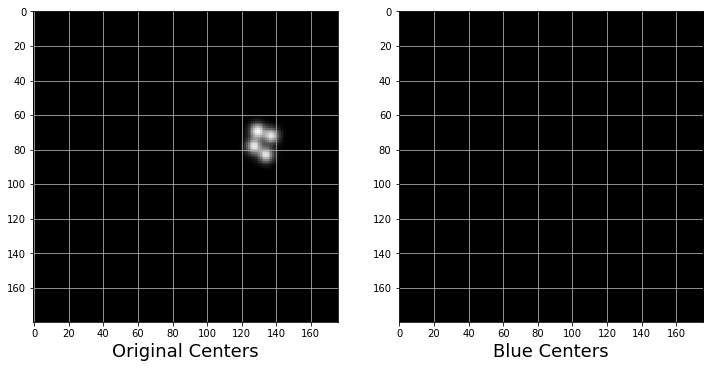

In [22]:
plt.subplot(1, 2, 1)
plt.imshow(labels[i])
plt.xlabel("Original Centers", fontsize=18)
plt.grid()
plt.subplot(1, 2, 2)
plt.imshow(blue[i])
plt.xlabel("Blue Centers", fontsize=18)
plt.grid()

In [23]:
# Red = false negative 
index_red = np.array(list(set(range(w.shape[0])) - set(index_testing))) # index of false negative
red = np.zeros(mask.shape, dtype=np.int16)
ones_red = np.int16(testing_coords[index_red])
red[ones_red[:, 0], ones_red[:, 1], ones_red[:, 2]] = 1
red = Dilation(red)

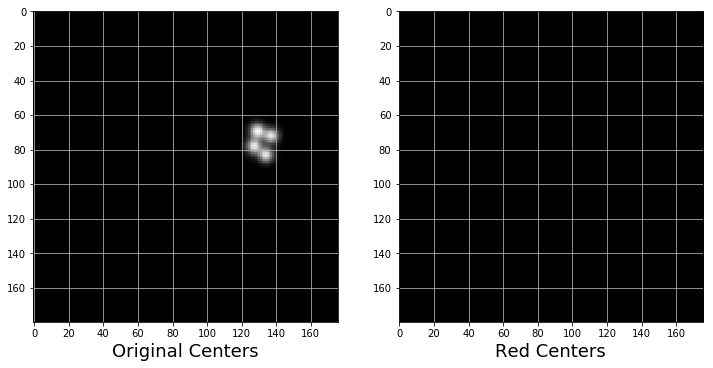

In [25]:
plt.subplot(1, 2, 1)
plt.imshow(labels[i])
plt.xlabel("Original Centers", fontsize=18)
plt.grid()
plt.subplot(1, 2, 2)
plt.imshow(red[i])
plt.xlabel("Red Centers", fontsize=18)
plt.grid()

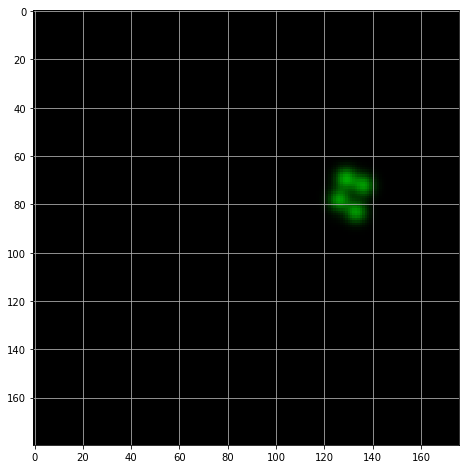

In [27]:
# Creation of the new final stack. In each RGB component we assign one of the results obtained

img = np.zeros(mask.shape + (3,), dtype=np.uint8)
img[..., 0] = red
img[..., 1] = green_testing
img[..., 2] = blue

plt.imshow(img[i])
plt.grid()

In [28]:
# Save a 'tiff' and use it with FIJI.

# import tifffile
# tifffile.imsave("/cvlabdata1/home/mas/Visualization_RGB/striatum_testing-Bouton4-worst.tif", img)
